# **Run Or Walk - VGG16 Transfer Learning** 

In [19]:
import os
import numpy as np  
import datetime
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [20]:
# -- Global Variables -- 
TRAIN_PATH = '/kaggle/input/walk-or-run/walk_or_run_train/train'
TEST_PATH = '/kaggle/input/walk-or-run/walk_or_run_test/test'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
GRAY_SCALL = (3,)
INPUT_SIZE = TARGET_SIZE + GRAY_SCALL
EPOCHS = 10
CLASSES = ['Run','Walk']

In [21]:
# -- Data Normalization --
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, #making sure that each image has a mean of 0 
                                                                 samplewise_std_normalization=True, #and standard deviation 1
                                                                 horizontal_flip=True, #Randomly flip inputs horizontally
                                                                 validation_split=0.3)

In [22]:
# -- Data iterators -- 
train_data = data_generator.flow_from_directory(directory=TRAIN_PATH, 
                                                    target_size=TARGET_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical', 
                                                    color_mode=COLOR_MODE, 
                                                    subset='training')         
    
validation_data = data_generator.flow_from_directory(directory=TRAIN_PATH, 
                                                    target_size=TARGET_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical', 
                                                    color_mode=COLOR_MODE, 
                                                    subset='validation')             

test_data = data_generator.flow_from_directory(directory=TEST_PATH, 
                                                   target_size=TARGET_SIZE, 
                                                   batch_size=BATCH_SIZE, 
                                                   class_mode='categorical', 
                                                   color_mode=COLOR_MODE)

Found 421 images belonging to 2 classes.
Found 179 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


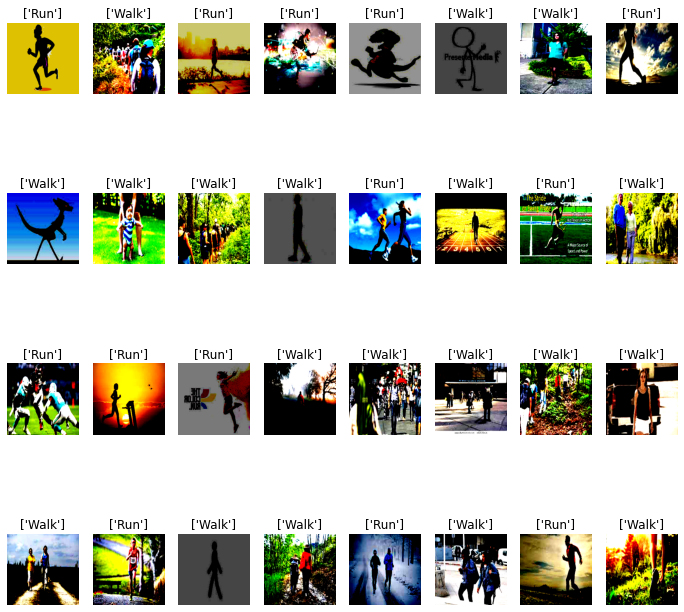

In [23]:
# -- plot random batch -- 
images, labels = train_data.next()
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 8, figsize=(12, 12))
axs = axs.flatten()

for img, l, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    l = l.astype(int)
    ax.set_title(classes[l == 1])

plt.show()

In [24]:
# -- Define model -- 
# since we have a small amount of data I'll use the trained weights of VGG16, 
# but I will change the last few layers, and train them.

def my_model():
    #Load vgg16 model without classifier layers
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SIZE)

    #Freeze the convolutional base
    vgg16_model.trainable = False
    
    #Add new classifier layers
    flatten = Flatten()(vgg16_model.layers[-1].output)
    fc1 = Dense(units=4096, activation='relu')(flatten)
    dropout = Dropout(0.2)(fc1) 
    fc2 = Dense(units=1024,activation='relu')(dropout)
    output = Dense(2, activation='softmax')(fc2)
   
    #Define a new modol
    model = Model(inputs = vgg16_model.input, outputs=output)
    
    #Model summary
    model.summary()
    
    return model

In [25]:
model = my_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [26]:
# -- Define optimizer and loss --
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = tf.keras.losses.CategoricalCrossentropy()

In [27]:
# -- Compile model --
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [28]:
 # -- Callbacks --
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', 
                                                    monitor='accuracy', verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False, 
                                                    mode='auto', 
                                                    save_freq='epoch')
    
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                    min_delta=0, 
                                                    patience=5,  #Number of epochs with no improvement after which training will be stopped.
                                                    verbose=1, 
                                                    mode='auto')
    
log_dir = './logs/fit/' + datetime.datetime.now().strftime('%m.%d.%Y--%H-%M-%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                 histogram_freq=1, 
                                                 write_graph=True,
                                                 write_images=False, 
                                                 update_freq='epoch')

In [29]:
# -- Train model --
history = model.fit(x=train_data, 
                        epochs=EPOCHS, 
                        steps_per_epoch=len(train_data), 
                        verbose=1, 
                        validation_data=validation_data, 
                        validation_steps=1, 
                        callbacks=[checkpoint, earlystoping, tensorboard])
    
# -- Save model -- 
model.save('my_model.h5')

Epoch 1/10
14/14 [==============================] - 108s 8s/step - loss: 6.6724 - accuracy: 0.4927 - val_loss: 0.6587 - val_accuracy: 0.6562

Epoch 00001: accuracy improved from -inf to 0.52732, saving model to my_model.h5
Epoch 2/10
14/14 [==============================] - 88s 6s/step - loss: 0.6399 - accuracy: 0.7252 - val_loss: 0.6591 - val_accuracy: 0.6562

Epoch 00002: accuracy improved from 0.52732 to 0.73872, saving model to my_model.h5
Epoch 3/10
14/14 [==============================] - 101s 7s/step - loss: 0.3577 - accuracy: 0.8242 - val_loss: 0.4327 - val_accuracy: 0.8125

Epoch 00003: accuracy improved from 0.73872 to 0.85748, saving model to my_model.h5
Epoch 4/10
14/14 [==============================] - 88s 6s/step - loss: 0.2019 - accuracy: 0.9074 - val_loss: 0.7175 - val_accuracy: 0.7500

Epoch 00004: accuracy improved from 0.85748 to 0.91686, saving model to my_model.h5
Epoch 5/10
14/14 [==============================] - 88s 6s/step - loss: 0.1031 - accuracy: 0.9623 - v

In [30]:
def learning_curves(history):
    '''plot learning curves'''
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss - Cross Entropy')
    plt.xlabel('epoch')
    plt.ylim([0,1.6])
    plt.title('Training and Validation Loss')
    
    plt.show()

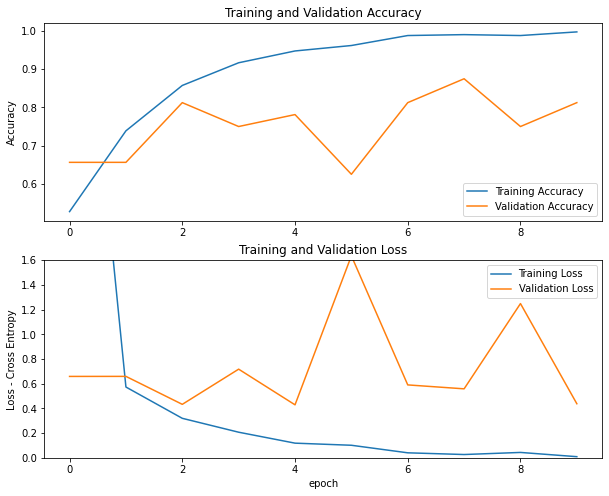

In [31]:
# -- Plot learning curves -- 
learning_curves(history)

In [32]:
# -- Evaluate the model on the test data -- 
loss, accuracy = model.evaluate(x=test_data)
print("test loss: ", loss, ", test acc: " , 100*accuracy, "%")

5/5 [==============================] - 26s 5s/step - loss: 1.1093 - accuracy: 0.7589
test loss:  1.1093034744262695 , test acc:  75.8865237236023 %


In [33]:
def run_or_walk(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224,3))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    model = tf.keras.models.load_model('my_model.h5')
    output = model.predict(img)
    print(classes[output[0]==1])

In [34]:
run_or_walk(TEST_PATH + '/run/run_82ee1773.png')

['Run']
